# Time-resolved probing

This is a recreation of figures and analysis from Ehrhardt & Weeks 2020 Figure 3.

[publication pdf](https://weekslab.com/wp-content/uploads/sites/9/2021/01/2020_je_jacs.pdf)

Raw sequencing reads, 3D structure, and 2D structure drawing were obtained from the authors. Raw sequencing reads were processed using Shapemapper2 and RingMapper. This results in the 8 required files for this analysis, included in this directory:
- 3dhsCrystal_PlusLoops.pdb
- RC_CRYSTAL_STRUCTURE.xrna
- RC0_rnasep_profile.txt
- RC0_rnasep_rings.txt
- RC30_rnasep_profile.txt
- RC30_rnasep_rings.txt
- RC1200_rnasep_profile.txt
- RC1200_rnasep_rings.txt

## Import RNAvigate

This first step in this notebook is to import the RNAvigate python module.

In [1]:
import rnavigate as rnav

## Load data

Here we have 3 samples, TMO-treated RNase P construct:
1. in the absence of Mg++
2. partially folded with Mg++ for 30 seconds
3. fully folded with Mg++ for 1200 seconds

In [2]:
rc0 = rnav.Sample(
    sample="No $Mg^{2+}$",
    dmsmap="RC0_rnasep_profile.txt",
    ringmap="RC0_rnasep_rings.txt",
    ss="RC_CRYSTAL_STRUCTURE.xrna",
    pdb={"filepath": "3dhsCrystal_PlusLoops.pdb",
         "chain":"A"})

rc30 = rnav.Sample(
    sample="partially folded",
    dmsmap="RC30_rnasep_profile.txt",
    ringmap="RC30_rnasep_rings.txt",
    ss="RC_CRYSTAL_STRUCTURE.xrna",
    pdb={"filepath": "3dhsCrystal_PlusLoops.pdb",
         "chain":"A"})

rc1200 = rnav.Sample(
    sample="fully folded",
    dmsmap="RC1200_rnasep_profile.txt",
    ringmap="RC1200_rnasep_rings.txt",
    ss="RC_CRYSTAL_STRUCTURE.xrna",
    pdb={"filepath": "3dhsCrystal_PlusLoops.pdb",
         "chain":"A"})

sample_list = [rc0, rc30, rc1200]

## Additional information for each sample

The raw sequencing reads used in this analysis differ slightly from the original
publication in that they are sequenced to much higher read-depth. This requires
a slightly different filtering scheme. Instead of filtering on $G_{apc}$, which
is dependent on read depth, I will filter using MI which is directly related to
$G_{apc}$, but does not depend on read depth.

$$ MI = \frac{G_{apc}}{2 * depth} \\ $$

Below, I calculate this value and add it to the "ringmap" dataframe for each sample, so that I can use it later to filter RINGs.

In addition, I am adding annotations for each of the regions defined in the
original publication, which are involved in the largest changes between
time-points.


In [3]:
for sample in sample_list:
    sample.data["ringmap"].data.eval("MI = 0.5 * Statistic / Mod_Depth", inplace=True)
    sample.set_data(
        name="catalytic core", instantiator=rnav.data.Annotation, seq_source="ss",
        span_list= [[236, 240], [181, 188], [45, 47], [49, 49], [127, 128]],
        color="DarkOrchid")
    sample.set_data(
        name="cc49", instantiator=rnav.data.Annotation, seq_source="ss",
        site_list=[49], color="DarkOrchid")
    sample.set_data(
        name="P5", instantiator=rnav.data.Annotation, seq_source="ss",
        span_list= [[58, 62], [101, 105]],
        color="orange")
    sample.set_data(
        name="P2", instantiator=rnav.data.Annotation, seq_source="ss",
        span_list= [[189, 195], [15, 21]],
        color="DodgerBlue")
    sample.set_data(
        name="loop-loop", instantiator=rnav.data.Annotation, seq_source="ss",
        span_list= [[70, 75], [141, 146]],
        color="red")
    sample.set_data(
        name="all", instantiator=rnav.data.Annotation, seq_source="ss",
        span_list= [[1, -1]],
        color="grey")
annotations_list = ["catalytic core", "cc49", "P5", "P2", "loop-loop"]

## Custom color list

I will use annotations below to highlight the important regions, but I also want
to color individual nucleotides by which region they are in. To acheive this, I
will make a custom list of colors, one color for each nucleotide in RNaseP.

In [4]:
c_list = rnav.get_color_list(
    length = rc0.data["ss"].length,
    default = "grey",
    color_regions = {
        "DarkOrchid":[[236, 240], [181, 188], [45, 47], [49, 49], [127, 128]],
        "DodgerBlue":[[189, 195], [15, 21]],
        "orange":[[58, 62], [101, 105]],
        "red": [[70, 75], [141, 146]]
    })

## Detailed structure

Here, I'm making a structure diagram that includes important details,
as a reference for the more data-rich plots I will be making later.

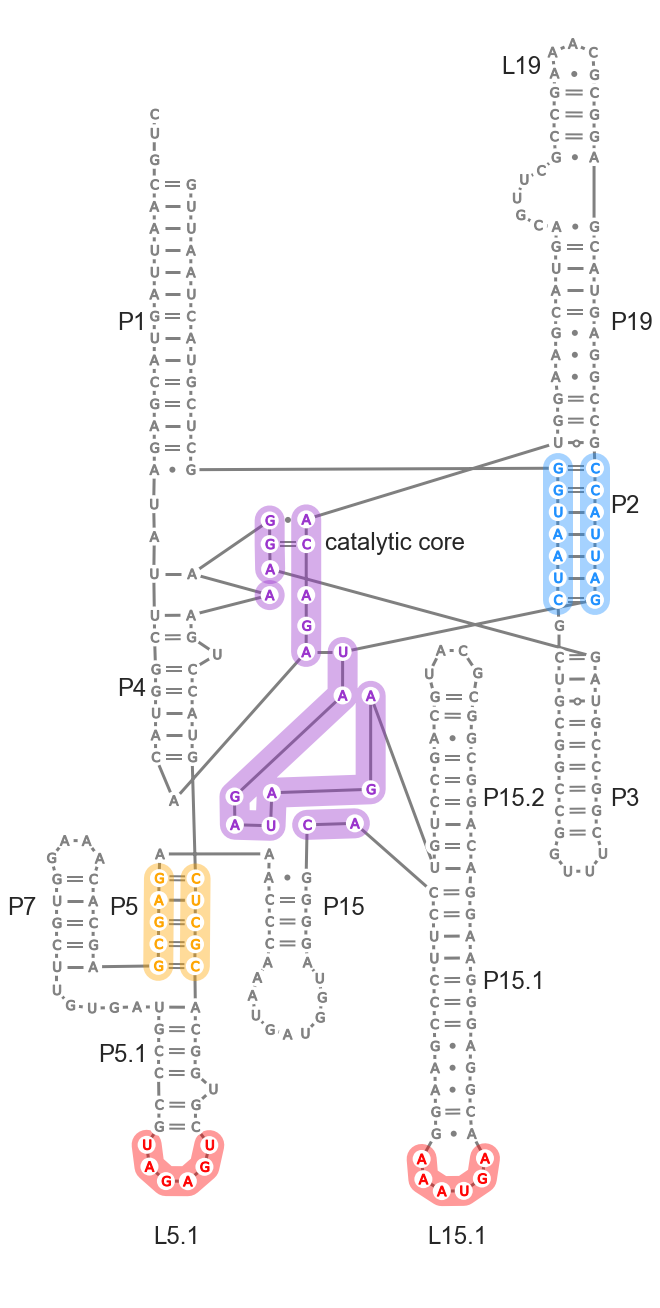

In [5]:
plot = rc0.plot_ss(                  # make a secondary structure diagram
    colors=c_list,                   # use our custom color list
    apply_color_to="sequence",       # apply these colors to the sequence letters
    annotations=annotations_list,    # highlight our important regions
    bp_style="conventional",         # use Westoff-Leonitis (ish) base-pairing conventions
    title=False,                     # do not add a title
)

ax = plot.axes[0,0]
# add these text labels to the plot axis
# ax.text(x position, y position, "displayed text")
ax.text(0.2, 4, "catalytic core")
ax.text(-5.5, 10, 'P1')
ax.text(-5.5, 0, 'P4')
ax.text(-5.7, -6, 'P5')
ax.text(-8.5, -6, 'P7')
ax.text(0.1, -6, 'P15')
ax.text(-6, -10, 'P5.1')
ax.text(5, 17, 'L19')
ax.text(8, 10, 'P19')
ax.text(8, 5, 'P2')
ax.text(8, -3, 'P3')
ax.text(4.5, -3, 'P15.2')
ax.text(4.5, -8, 'P15.1')
ax.text(3, -15, 'L15.1')
ax.text(-4.5, -15, 'L5.1');
# plot.save("full_ss.svg")


## RINGs on secondary structure

Next, for each of the samples, I will plot the RING-MaP interactions in green
on my secondary structure file.

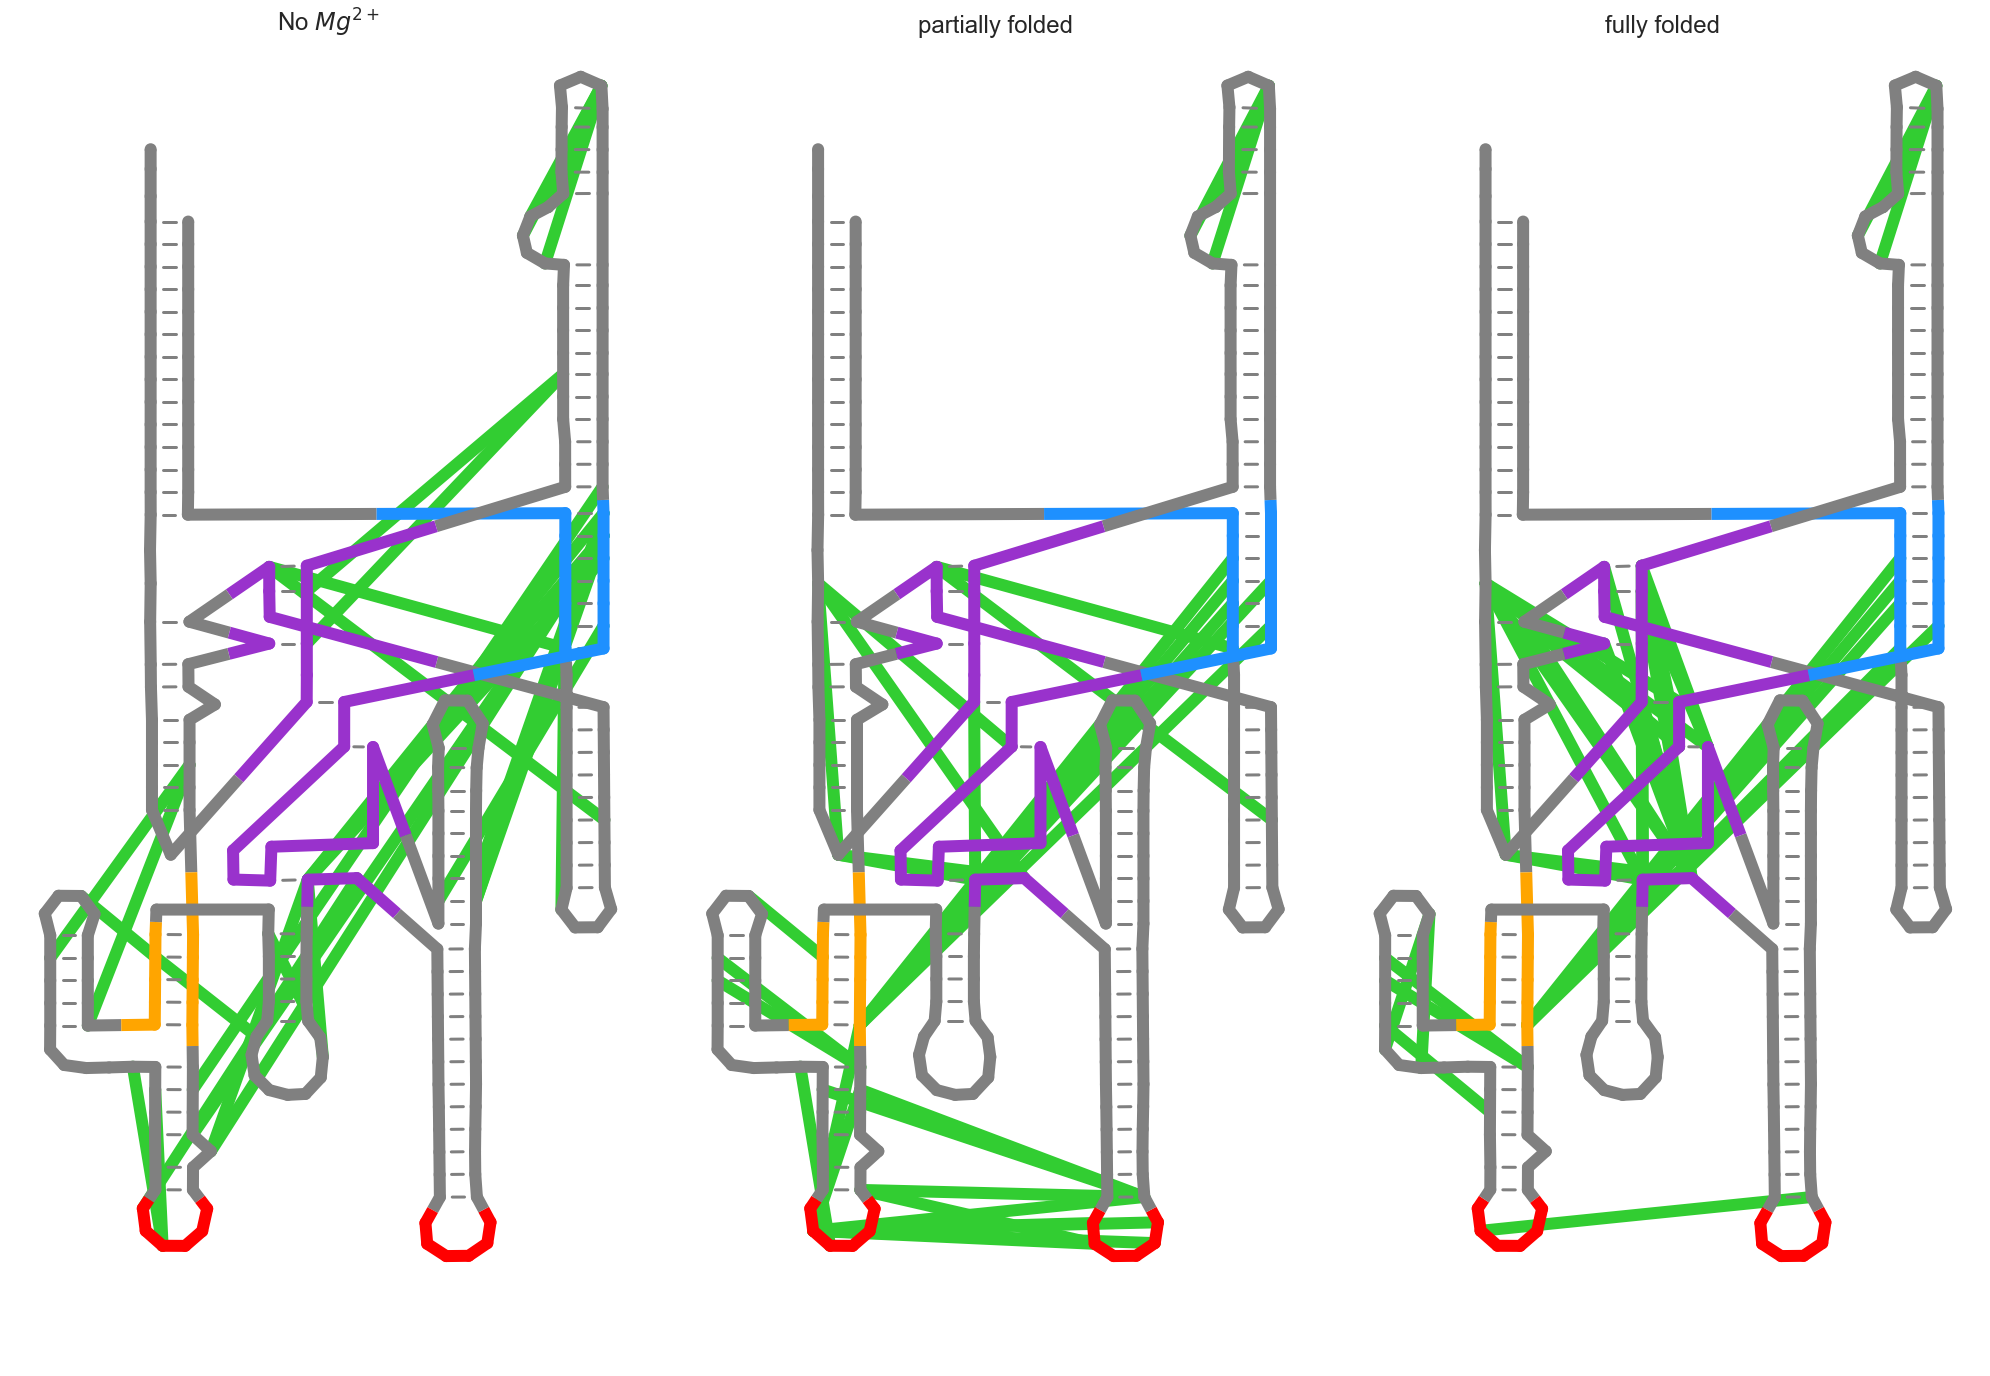

In [6]:
# These parameters are used to filter RINGs
ij_filter = {
    'ct': 'ss',            # use the "ss" structure drawing to filter by structural features
    'MI_ge': 0.00025,      # Only include RINGs with MI value greater than or equal to 0.00015
    'Statistic_ge':23,     # Only include RINGs with Gapc value greater than or equal to 23
    'min_cd': 5,           # Only include RINGs with contact distance of at least 5
    'positive_only': True, # Only include RINGs with a positive correlation
    'cmap':'limegreen'}    # Set the color of all rings to "limegreen"

# These parameters change plot appearance and relate to matplotlib options
plot_kwargs={
    "data_lw": 12,         # lw=linewidth
    "data_a": 1,           # a=alpha
    "marker_s": 20**2,     # s=size
    "structure_z": 40,     # z=z-value
    "structure_lw": 12,
    "basepair_z": 39}

plot = rnav.plot_ss_multisample(
    samples=sample_list,           # Make one structure diagram for each sample in our list
    interactions="ringmap",        # show ringmap interactions
    interactions_filter=ij_filter, # use filters defined above
    colorbar=False,                # do not display colorbar
    bp_style="line",               # represent base-pairs with solid lines
    colors=c_list,                 # Apply custom color list to:
    apply_color_to="structure",    # the backbone of the structure
    plot_kwargs=plot_kwargs)       # Apply the above appearance changes


## Separating newly-formed RINGs from those present in previous time-points

The above plot is nice, but I would like to convey additional information. Some
of these RINGs are newly formed at each time-point, and some are carried over
from a previous time-point. I would like to color these differently.
The code below includes some advanced manipulations of the underlying dataframes
in order to acheive this effect.

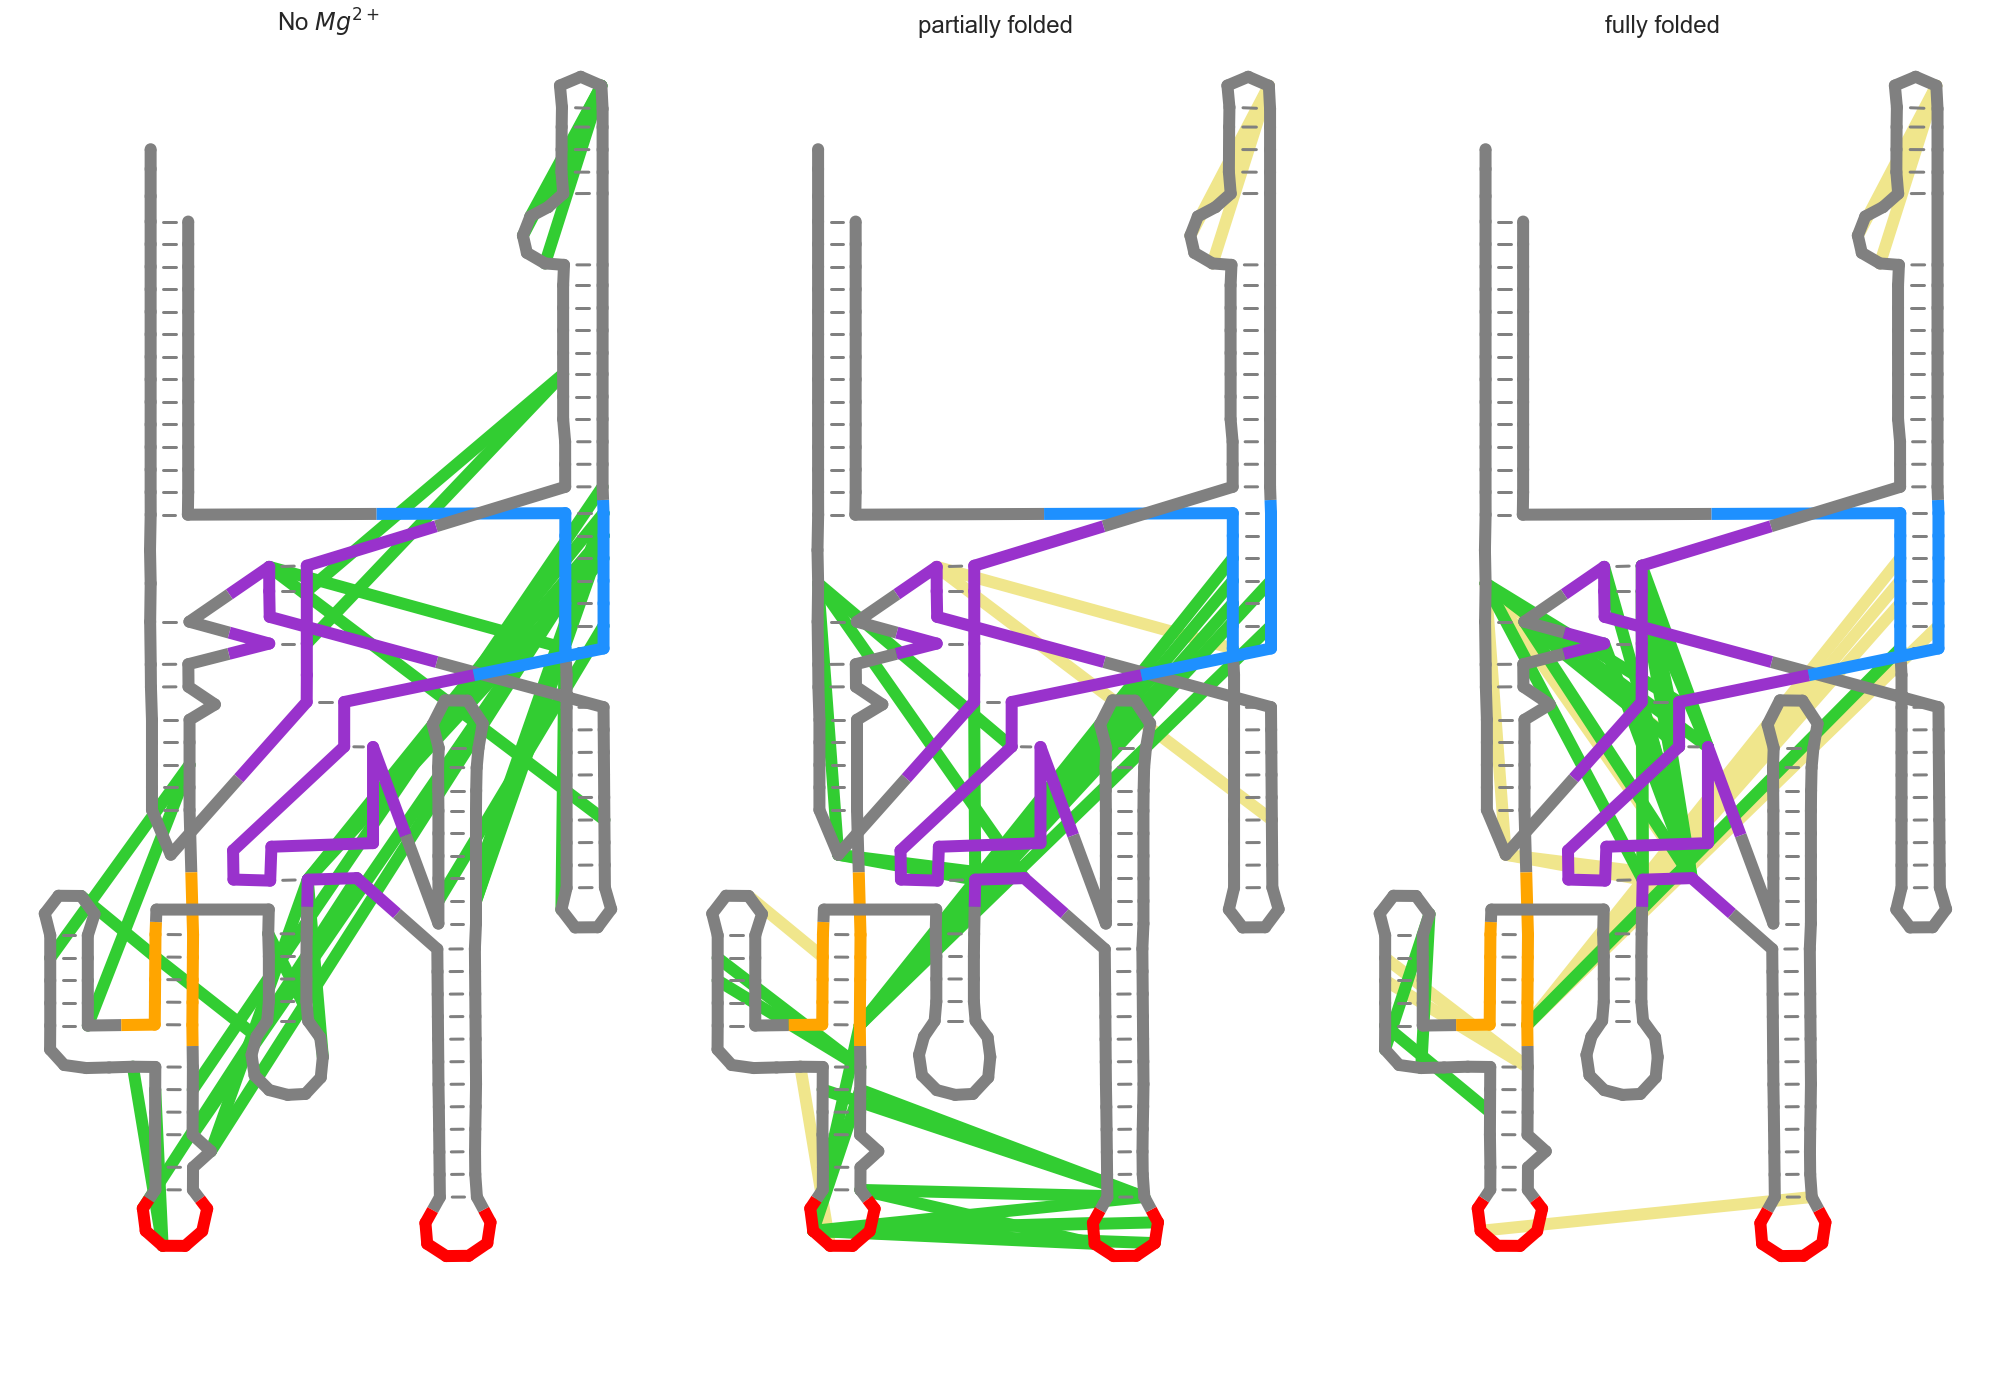

In [7]:
import numpy as np
ij_filter = {
    'fit_to': 'ss',
    'ct': 'ss',
    'MI_ge': 0.00025,
    'Statistic_ge':23,
    'min_cd': 5,
    'positive_only': True}

s1 = rc0
s2 = rc30
s3 = rc1200
s1.filter_interactions("ringmap", **ij_filter, cmap="limegreen")
s2.filter_interactions("ringmap", **ij_filter, cmap="khaki")
s3.filter_interactions("ringmap", **ij_filter, cmap="khaki")

# RINGs in rc1200 are included only if there is a match in rc30
mask3 = np.array([True]*s3.data["ringmap"].data.shape[0])
comp_data = s2.data["ringmap"].data[s2.data["ringmap"].data["mask"]].copy()
for i, row in s3.data["ringmap"].data.iterrows():
    mask3[i] = not any((comp_data["i_offset"] == row["i_offset"])
                     & (comp_data["j_offset"] == row["j_offset"]))
s3.data["ringmap"].update_mask(~mask3)

# RINGs in rc30 are included only if there is a match in rc0
mask2 = np.array([True]*s2.data["ringmap"].data.shape[0])
comp_data = s1.data["ringmap"].data[s1.data["ringmap"].data["mask"]].copy()
for i, row in s2.data["ringmap"].data.iterrows():
    mask2[i] = not any((comp_data["i_offset"] == row["i_offset"])
                     & (comp_data["j_offset"] == row["j_offset"]))
s2.data["ringmap"].update_mask(~mask2)

# creating 3 panel structure diagram with:
# all RINGs for rc0 in green
# previously formed RINGs in khaki for rc30 and rc1200
plot = rnav.plot_ss_multisample(
    samples=sample_list,
    interactions="ringmap",
    prefiltered=True,
    colorbar=False,
    bp_style="line",
    colors=c_list,
    apply_color_to="structure",
    plot_kwargs=plot_kwargs)

# invert the filters above in order to plot newly formed RINGs above
# previously formed RINGs.
s2.filter_interactions("ringmap", **ij_filter, cmap="limegreen")
s3.filter_interactions("ringmap", **ij_filter, cmap="limegreen")
s3.data["ringmap"].update_mask(mask3)
s2.data["ringmap"].update_mask(mask2)

# adding these interactions to those plotted above
plot.plot_interactions(plot.axes[0,1], s2.data["ringmap"], False, 0)
plot.plot_interactions(plot.axes[0,2], s3.data["ringmap"], False, 0)

## RINGs and regions of interest using heatmaps

Heatmaps are a good way to view very dense 2D data, but they can be hard to
interpret. The reader is helped here by highlighting regions which
illustrate the appearance of time-dependent structural interactions.

Here, I'm using the kernal density estimate ("kde") to further simplify the
visualization, an improvement over the published figure.

Text(75, 50, 'P2-P5,P7')

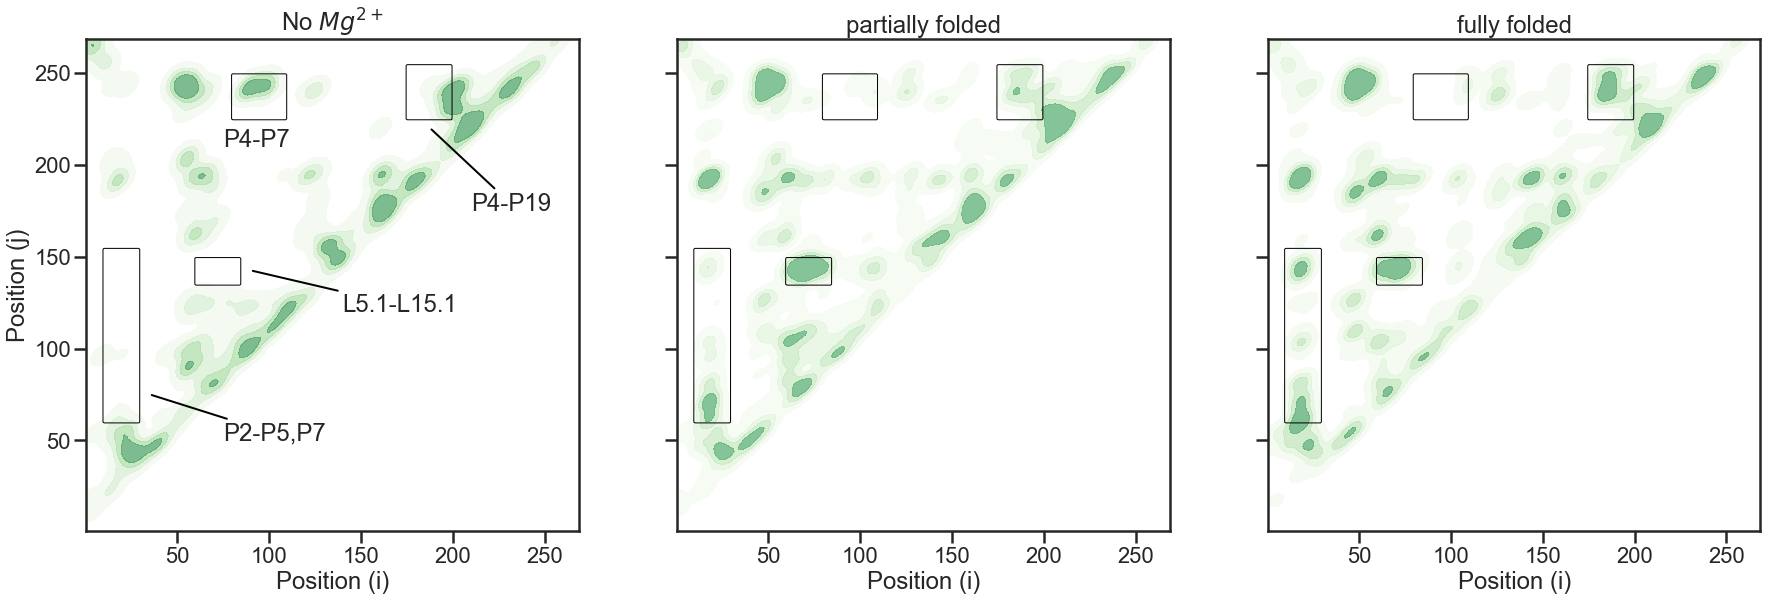

In [8]:
regions = [((225,250), (80,110)),     # ((x1, x2), (y1, y2))
           ((225,255), (175,200)),    # highlights interactions between region
           ((135,150), (60,85)),      # x1-x2 and y1-y2
           ((60,155), (10, 30))]

plot = rnav.plot_heatmap_multisample(
    samples=sample_list,        # 1 plot for each of three samples
    structure="ss",             # use nucleotide positions from "ss" data (excludes the structure cassetes)
    interactions="ringmap",     # Plot RING-MaP interactions
    interactions_filter={
        "positive_only": True,  # remove negative correlations
        "cmap": "Greens",       # use matplotlib "Greens" colormap
        "min_max": [0, 100]},   # colormap goes from 0 (white) to 100 (green)
    regions=regions,            # draw boxes around regions
    plot_type="kde")            # plot RINGs density instead of individual RINGs

# adding labels to region boxes
ax = plot.axes[0,0]
arrowprops = {'arrowstyle':'-', 'color': 'black'}
ax.annotate("P4-P7", [75, 210])
ax.annotate("P4-P19", [187.5, 220], [210, 175], arrowprops=arrowprops)
ax.annotate("L5.1-L15.1", [90, 142.5], [140, 120], arrowprops=arrowprops)
ax.annotate("P2-P5,P7", [35, 75], [75, 50], arrowprops=arrowprops)

## RINGs on 3D structure

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

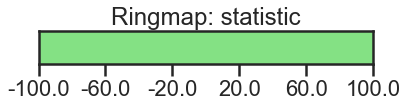

In [9]:
ij_filter = {
    'ct': 'ss',
    'MI_ge': 0.00025,
    'Statistic_ge':23,
    'min_cd': 5,
    'positive_only': True,
    'cmap': "limegreen"}

plot = rc1200.plot_mol(
    interactions="ringmap",
    interactions_filter=ij_filter,
    nt_color=c_list,
    hide_cylinders=True,
    width=800, height=800,
    background_alpha=0,
    title=False)